Projekt 4
Zbuduj pipeline uruchamiany przez Snakemake, który łączy:
1) obliczenia/analitykę stężeń PM2.5 (korzystając z kodu już zrobionego w Mały Projekt 1/Mały Projekt 3),
2) automatyczny mini-przegląd literatury (PubMed) dla wskazanych lat z użyciem Biopython (Bio.Entrez),
3) raport końcowy zestawiający wyniki PM2.5 i trendy w publikacjach.

Kluczowy wymóg: pipeline ma być „incremental” i nie przeliczać rzeczy ponownie, jeśli rok już był policzony (np. 2024 występuje w wielu uruchomieniach).

Wejście użytkownika
Użytkownik podaje listę lat w pliku konfiguracyjnym, np. config/task4.yaml:

years: [2021, 2024] (przykład uruchomienia 1)
później: years: [2019, 2024] (przykład uruchomienia 2)
Dodatkowo w configu są:
- miasta (np. Warszawa, Katowice – zgodnie z projektem),
- parametry obliczeń/normalizacji (jeśli są wymagane przez istniejący kod),
- parametry PubMed (zapytania + email + limit wyników).

Założenia (co już istnieje z poprzednich małych projektów 1–3)
Repo zawiera moduły/ funkcje do:
wczytania i czyszczenia danych PM2.5,
obliczenia metryk (np. średnie dobowe, dni z przekroczeniem normy),
wizualizacji/raportowania (opcjonalnie).
Możesz ich używać „jak biblioteki”, tzn. Snakemake ma jedynie je wywołać.
Repo ma (lub potrafi stworzyć) surowe dane, ale Task 4 nie zmienia logiki liczenia – tylko ją odpala.
Wyniki (artefakty)
Dla każdego roku Y pipeline tworzy dwie niezależne gałęzie wyników:

A) PM2.5:
- results/pm25/{Y}/exceedance_days.csv (lub analogiczny plik z Twojego projektu)
- results/pm25/{Y}/daily_means.csv (jeśli jest w projekcie)
- opcjonalnie wykresy: results/pm25/{Y}/figures/*.png

B) Literatura:
- results/literature/{Y}/pubmed_papers.csv (PMID, tytuł, rok, journal, autorzy; abstrakt opcjonalnie)
- results/literature/{Y}/summary_by_year.csv (dla zapytania – liczba publikacji per rok, min. do wykresu)
- results/literature/{Y}/top_journals.csv (np. top 10)
- opcjonalnie wykres: results/literature/{Y}/papers_per_year.png

Całość:
- results/report_task4.md (lub HTML/notebook) – raport zbiorczy dla lat z configu.

Wymagana funkcjonalność Biopython/PubMed
Zaimplementuj skrypt src/literature/pubmed_fetch.py, który:
1) przyjmuje argumenty: --year Y, --config config/task4.yaml,
2) wykonuje wyszukiwanie PubMed (Entrez.esearch) dla zapytań z configu ograniczonych do danego roku (np. filtrem dat),
3) pobiera metadane (Entrez.esummary lub efetch),
4) zapisuje results/literature/{Y}/pubmed_papers.csv,
5) generuje agregacje (summary_by_year, top_journals) dla tego roku.

W configu wymagane jest entrez_email (dobre praktyki NCBI).

Integracja z wynikami PM2.5
Stwórz raport (markdown lub notebook) np. results/report_task4.md, który zawiera:
- krótkie podsumowanie wyników PM2.5 z istniejących artefaktów (np. tabelka przekroczeń per rok/miasto),
- sekcję “Literatura”:
- ile publikacji znaleziono dla każdego zapytania,
- trend liczby publikacji w czasie,
- top czasopisma,
- kilka przykładowych tytułów (max 5) jako ilustracja.

Snakemake: struktura i „incrementalność”
Dodaj Snakefile_task4 (albo rozbuduj istniejący Snakefile) tak, aby:

1) rule pm25_year
- uruchamia istniejący kod z małych projektów 1/3 dla danego roku Y
- tworzy results/pm25/{Y}/...

2) rule pubmed_year
- uruchamia pubmed_fetch.py --year {Y}
- tworzy results/literature/{Y}/...

3) rule report_task4
- zbiera wyniki tylko dla lat wskazanych w configu
- składa raport results/report_task4.md

Wymóg kluczowy: „2024 nie przeliczamy drugi raz”
Snakemake ma naturalnie zapewnić, że:
- jeśli results/pm25/2024/exceedance_days.csv już istnieje i jego wejścia się nie zmieniły,
to przy kolejnych uruchomieniach pipeline nie wykona reguły dla 2024,
- analogicznie dla literatury: jeśli istnieje results/literature/2024/pubmed_papers.csv i config/zapytania się nie zmieniły,
to nie pobieramy ponownie.

Scenariusz działania (wprost wymagany do pokazania)
1) Użytkownik ustawia:
- years: [2021, 2024]
Uruchamia:
- snakemake -s Snakefile_task4 --cores 1
Pipeline liczy:
- PM2.5 dla 2021 i 2024
- PubMed dla 2021 i 2024
- raport dla {2021, 2024}

2) Użytkownik zmienia config na:
- years: [2019, 2024]
Uruchamia ponownie tę samą komendę.
Pipeline ma wykonać tylko brakujące kroki:
- policzyć PM2.5 dla 2019 (2024 ma zostać pominięty),
- pobrać/analitykę PubMed dla 2019 (2024 ma zostać pominięty),
- wygenerować nowy raport dla {2019, 2024}.

W README opisz krótko (2–4 zdania), jak to weryfikujesz:
- np. po logach Snakemake (“Nothing to be done” dla 2024) lub przez porównanie czasu wykonania.

Minimalne wymagania jakości
README: “jak uruchomić Task 4” + opis scenariusza 1-2.
co najmniej 1 test pytest (np. poprawne parsowanie roku z PubMedDate, lub normalizacja rekordu publikacji).
kod pubmed_fetch.py ma działać deterministycznie na tym samym configu (te same wejścia - ten sam format wyjścia).
pipeline tworzy osobne katalogi wyników per rok i nie nadpisuje wyników innych lat.

In [2]:
!git clone https://github.com/aleksandraburakowska1/projekt45.git


Cloning into 'projekt45'...
remote: Enumerating objects: 252, done.
remote: Counting objects: 100% (252/252), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 252 (delta 107), reused 196 (delta 75), pack-reused 0 (from 0)
Receiving objects: 100% (252/252), 7.43 MiB | 22.24 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [3]:
%cd /content/projekt45


/content/projekt45


In [4]:
import pandas as pd
import requests
import zipfile
import io, os

from io_clean import (
    download_gios_archive,
    usun_wiersze_opisowe,
    load_gios_metadata,
    use_station_header,
    build_old2new,
    mapuj_kolumny_z_podgladem,
    build_kod2miasto,
    dodaj_multiindex,
)



In [5]:
from metrics import (
    ensure_datetime,
    shift_midnight_to_prev_day,
    add_city_and_month,
    daily_station_mean,
    exceedance_days_per_year,
    select_top_bottom_stations
)

In [6]:
from viz import (

    plot_monthly_pm25,
    plot_pm25_heatmaps
)

In [ ]:
import os
from pathlib import Path

os.chdir("/content/Maly_projekt3_Ola_i_Michal")
print("PWD:", Path.cwd())


PWD: /content/Maly_projekt3_Ola_i_Michal


In [ ]:
from pathlib import Path

conftest = r'''
import sys
from pathlib import Path

ROOT = Path(__file__).resolve().parents[1]
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
'''

Path("tests/conftest.py").write_text(conftest, encoding="utf-8")
print("OK: dodano tests/conftest.py")


OK: dodano tests/conftest.py


In [ ]:
!pytest -q


..........                                                               [100%]
10 passed in 0.75s


In [ ]:
# id archiwum dla poszczególnych lat
gios_archive_url = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/"
#zmieniam lata
gios_url_ids = {2015: '236', 2018: '603', 2019: '322', 2021: '486', 2024: '582'}
gios_pm25_file = {2015: '2015_PM25_1g.xlsx', 2018: '2018_PM25_1g.xlsx', 2019: '2019_PM25_1g.xlsx', 2021: '2021_PM25_1g.xlsx', 2024: '2024_PM25_1g.xlsx'}
meta_path = "Metadane oraz kody stacji i stanowisk pomiarowych.xlsx"
dfmeta = load_gios_metadata(meta_path)

# Przykladowe użycie
#df2024 = download_gios_archive(2024, gios_url_ids[2024], gios_pm25_file[2024])

In [ ]:
#zmiana zalecana przez prowadzącego
lata = [2015, 2018, 2021, 2024]

datasets = {}
for rok in lata:
    datasets[rok] = download_gios_archive(rok, gios_url_ids[rok], gios_pm25_file[rok])

datasets[2024].head(10)


ChunkedEncodingError: ('Connection broken: IncompleteRead(62403554 bytes read, 13433330 more expected)', IncompleteRead(62403554 bytes read, 13433330 more expected))

In [ ]:

#tutaj w tym fragmencie usuwam niepotrzebne wiersze (np. "wskaźnik")
# słownik z danymi źródłowymi (twoje DataFrame’y)

#zmienione według uwag prowadzącego

cleaned = usun_wiersze_opisowe(datasets)
cleaned[2015].head()
#odnosząc do poprzedniego: zamiast df2024_clean → używamy cleaned[2024]


2015: usunięto 2 wierszy opisowych, pozostało 8761
2018: usunięto 5 wierszy opisowych, pozostało 8761
2021: usunięto 5 wierszy opisowych, pozostało 8761
2024: usunięto 5 wierszy opisowych, pozostało 8785


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,Kod stacji,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,KpToruDziewu,LbLubObywate,LdLodzCzerni,LdLodzGdansk,...,SkMalo11List,SkPolaRuszcz,SlGliwicMewy,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,WpPoznPolank,ZpSzczAndr01,ZpSzczPils02
1,2015-01-01 01:00:00,151.112,78,50,29.2,95.5,27.352,71.1012,59.73,NaN,...,39.6,72.4,77.828,51.389,49.9464,44.060833,25.5,24.4768,NaN,NaN
2,2015-01-01 02:00:00,262.566,42,33.8244,27.1,86.1,78.0064,95.2582,185.92,NaN,...,33.6,57.2,50.0552,37.709,45.6291,49.943329,32.5,29.86,81.8501,215.379
3,2015-01-01 03:00:00.005000,222.83,27,28.7215,7.9,23.8,21.1056,49.5078,54.25,NaN,...,35,41.9,52.0277,41.984,49.2093,20.688448,24.3,29.3744,25.7333,27.7458
4,2015-01-01 04:00:00.010000,210.767,24,20.6891,7.1,15.9,16.9088,60.8468,50.15,NaN,...,34.8,36.7,49.1084,45.404,53.316,17.437717,24.4,28.34,18.624,26.5201


In [ ]:
#mapowanie stary kod: nowy kod w słowniku
old2new = build_old2new(dfmeta)
old2new

{'DsBogatMob': 'DsBogatFrancMOB',
 'DsCzer02': 'DsCzerStraza',
 'DsDzia01': 'DsDzialoszyn',
 'DsDzierPilsA': 'DsDziePilsud',
 'DsGlogWita': 'DsGlogWiStwo',
 'DsJeleniaGoraA': 'DsJelGorOgin',
 'DsJeleniaGoraPM': 'DsJelGorSoko',
 'DsKlodzkoA': 'DsKlodzSzkol',
 'DsZabkowSemi': 'DsZabkPowWar',
 'DsPolanZdrojMOB': 'DsKudSlon',
 'DsLegRzeczA': 'DsLegPolarna',
 'DsNRudaSrebP': 'DsNowRudSreb',
 'DsOlawaSemi': 'DsOlawZolnAK',
 'DsOlesnicaPM': 'DsOlesBrzozo',
 'DsOsieczow': 'DsOsieczow21',
 'DsPolkKasz': 'DsPolKasztan',
 'DsSniezka': 'DsSniezkaObs',
 'DsSwidMob': 'DsSwidnMarciMOB',
 'DsSwidRynek': 'DsSwidnRynek',
 'DsSzczDZPM': 'DsSzczaKolej',
 'DsTrzebnica': 'DsTrzebniMaj',
 'DsWalbWysA': 'DsWalbrzWyso',
 'DsWrocWisA': 'DsWrocAlWisn',
 'DsWrocBartA': 'DsWrocBartni',
 'DsWrocGrobla': 'DsWrocNaGrob',
 'DsWrocKorzA': 'DsWrocWybCon',
 'DsZgorzBohA': 'DsZgorBohGet',
 'DsZlotoryjaPM': 'DsZlotoStasz',
 'KpBrodnicaKochanowskiego': 'KpBrodKochan',
 'KpBydgBerlinga': 'KpBydFieldor',
 'KpBydBerling': 'KpB

In [ ]:
#Zamiana wiersza "Kod stacji" na nagłówek i dodanie kolumny 'Data', żeby ujednolicić format
#potem zmapuję stare kody stacji na nowe zgodnie z metadanymi (słownik powyżej)

hdr = {}
for rok in lata:
    hdr[rok] = use_station_header(cleaned[rok])
hdr[2015]

,Data,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,KpToruDziewu,LbLubObywate,LdLodzCzerni,LdLodzGdansk,...,SkMalo11List,SkPolaRuszcz,SlGliwicMewy,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,WpPoznPolank,ZpSzczAndr01,ZpSzczPils02
0,2015-01-01 01:00:00,151.112,78,50,29.2,95.5,27.352,71.1012,59.73,NaN,...,39.6,72.4,77.828,51.389,49.9464,44.060833,25.5,24.4768,NaN,NaN
1,2015-01-01 02:00:00,262.566,42,33.8244,27.1,86.1,78.0064,95.2582,185.92,NaN,...,33.6,57.2,50.0552,37.709,45.6291,49.943329,32.5,29.86,81.8501,215.379
2,2015-01-01 03:00:00.005000,222.83,27,28.7215,7.9,23.8,21.1056,49.5078,54.25,NaN,...,35,41.9,52.0277,41.984,49.2093,20.688448,24.3,29.3744,25.7333,27.7458
3,2015-01-01 04:00:00.010000,210.767,24,20.6891,7.1,15.9,16.9088,60.8468,50.15,NaN,...,34.8,36.7,49.1084,45.404,53.316,17.437717,24.4,28.34,18.624,26.5201
4,2015-01-01 05:00:00.015000,191.211,22,22.5335,9.2,15,16.8112,49.3106,39.17,NaN,...,35.8,36,44.0588,36.854,51.5259,15.532262,25,25.2286,17.6545,31.0393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2015-12-31 20:00:43.770000,13.7734,29.2072,24.4965,NaN,76.2,NaN,62.7976,31,57,...,28,59,205.944,158.52,42.9334,34.510277,75.05,36.3858,30.6219,30.2969
8756,2015-12-31 21:00:43.775000,20.8195,36.8677,39.4025,55.4,66.9,NaN,105.59,46,60,...,36.8,57.4,218.516,143.729,45,35.861,62.8491,40.31,50.1254,27.2376
8757,2015-12-31 22:00:43.780000,11.7978,61.041,52.4493,NaN,69.2,NaN,232.0938,46,58,...,33.3,73.8,169.238,131.673,63.9197,36.309914,70.6655,43.079,38.0602,28.3642
8758,2015-12-31 23:00:43.785000,16.6281,67.5414,59.3307,71.1,65.5,NaN,203.4012,49,57,...,38.2,70.9,115.688,119.533,56.2223,38.686676,80.2882,52.32,193.129,34.8272


In [ ]:

kod2miasto = build_kod2miasto(dfmeta)
kod2miasto


{'DsBialka': 'Białka',
 'DsBielGrot': 'Bielawa',
 'DsBogatFrancMOB': 'Bogatynia',
 'DsBogChop': 'Bogatynia',
 'DsBogZatonieMob': 'Bogatynia',
 'DsBoleslaMOB': 'Bolesławiec',
 'DsBrzegGlog': 'Brzeg Głogowski',
 'DsChojnowKil': 'Chojnów',
 'DsChojnowMalMOB': 'Chojnów',
 'DsCzar07': 'Czarna Góra',
 'DsCzerStraza': 'Czerniawa',
 'DsCzLasMob': 'Czarny Las',
 'DsDusznikMOB': 'Duszniki-Zdrój',
 'DsDuszZiel': 'Duszniki-Zdrój',
 'DsDzialoszyn': 'Działoszyn',
 'DsDziePilsud': 'Dzierżoniów',
 'DsDzierKras': 'Dzierżoniów',
 'DsGlogMob': 'Głogów',
 'DsGlogNorw': 'Głogów',
 'DsGlogNorwArch': 'Głogów',
 'DsGlogOrzech': 'Głogów',
 'DsGlogowko': 'Głogówko',
 'DsGlogSikor': 'Głogów',
 'DsGlogWiStwo': 'Głogów',
 'DsGrodziec': 'Grodziec Mały',
 'DsJasnaSport': 'Jasna Góra',
 'DsJawDmow': 'Jawor',
 'DsJaworMOB': 'Jawor',
 'DsJedlinaZdrMOB': 'Jedlina-Zdrój',
 'DsJedlZdroj': 'Jedlina-Zdrój',
 'DsJelGorOgin': 'Jelenia Góra',
 'DsJelGorSoko': 'Jelenia Góra',
 'DsJelw05': 'Jeleniów',
 'DsJgCiep': 'Jelenia Góra'

In [ ]:
mapped = {}
for rok in lata:
    mapped[rok] = mapuj_kolumny_z_podgladem(hdr[rok], old2new)

 Zmienione kolumny:
   PdBialWaszyn  →  PdBialUpalna
   PmGdaLeczk08  →  PmGdaLeczkow
   PmKosTargo12  →  PmKosTargowa
   ZpSzczAndr01  →  ZpSzczAndrze
   ZpSzczPils02  →  ZpSzczPilsud
 Zmienione kolumny:
   MzKonJezMos  →  MzKonJezWieMOB
   PdBialWaszyn  →  PdBialUpalna
   PdSuwPulaskp  →  PdSuwPulask2
   PmGdaLeczk08  →  PmGdaLeczkow
   PmKosTargo12  →  PmKosTargowa
   ZpSzczAndr01  →  ZpSzczAndrze
   ZpSzczPils02  →  ZpSzczPilsud
 Zmienione kolumny:
   PdBialWaszyn  →  PdBialUpalna
 Żadna kolumna nie wymagała zmiany.


In [ ]:
mapped_proc = {}

for rok in lata:
    df_dt = ensure_datetime(mapped[rok])
    df_shift = shift_midnight_to_prev_day(df_dt)
    mapped_proc[rok] = df_shift


Kolumna Data przekonwertowana na datetime (błędne wartości: 0)
Kolumna Data przekonwertowana na datetime (błędne wartości: 0)
Kolumna Data przekonwertowana na datetime (błędne wartości: 0)
Kolumna Data przekonwertowana na datetime (błędne wartości: 0)
Kolumna Data przekonwertowana na datetime (błędne wartości: 0)
Kolumna Data przekonwertowana na datetime (błędne wartości: 0)
Kolumna Data przekonwertowana na datetime (błędne wartości: 0)
Kolumna Data przekonwertowana na datetime (błędne wartości: 0)


In [ ]:
df_all = pd.concat(
    [mapped_proc[rok] for rok in lata],
    join="inner",
    ignore_index=True
)


In [ ]:
df_all[df_all['Data'].dt.year == 2018].head()

,Data,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,LbLubObywate,LdLodzCzerni,LdZgieMielcz,LuZielKrotka,...,PdBialUpalna,PkPrzemGrunw,PmGdaLeczkow,PmKosTargowa,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,ZpSzczAndrze,ZpSzczPilsud
8760,2018-01-01 01:00:00,"43,0102","71,494","70,2","49,2716","69,6873","30,9","16,0","91,757",NaN,...,"16,0","12,268","92,1811",NaN,"76,8469","25,9266","41,3687",NaN,"26,5445","12,8035"
8761,2018-01-01 02:00:00,"5,38425","7,89305","13,1522","36,236","42,3178","54,8","83,0","54,707","8,42542",...,"11,0","7,84633","23,5344","5,74148","39,3395","32,7522","25,8502",NaN,NaN,NaN
8762,2018-01-01 03:00:00,"4,52882","12,5392","12,5","14,7514",NaN,"24,3","16,0","17,657","14,936",...,"25,0","7,01749","14,8063","8,72956","23,2554","37,6664","22,4599",NaN,"10,4332","32,0944"
8763,2018-01-01 04:00:00,"8,68036","5,03196","8,85164","17,1654",NaN,"15,1","14,0","4,832","11,0771",...,"20,0","8,08144","13,6979","10,7329","22,3614","32,4625","20,1625",NaN,"28,1885","27,3274"
8764,2018-01-01 05:00:00,"7,2","11,9136","7,29656","12,5788",NaN,"12,6","12,0","7,682","11,3799",...,"25,0","7,90984","11,952","10,9749","28,9092","27,135","18,3681",NaN,"40,1738","61,1957"


In [ ]:
#MultiIndex to po prostu wielopoziomowy indeks — czyli taki, gdzie:
#każda kolumna (lub wiersz) ma kilka warstw etykiet zamiast jednej.
df_all_multi = dodaj_multiindex(df_all, kod2miasto)
df_all_multi.head(10)


Miejscowość                         Jelenia Góra      Wrocław               \
Kod stacji                     Data DsJelGorOgin DsWrocAlWisn DsWrocWybCon   
0           2015-01-01 01:00:00.000      151.112           78           50   
1           2015-01-01 02:00:00.000      262.566           42      33.8244   
2           2015-01-01 03:00:00.005       222.83           27      28.7215   
3           2015-01-01 04:00:00.010      210.767           24      20.6891   
4           2015-01-01 05:00:00.015      191.211           22      22.5335   
5           2015-01-01 06:00:00.020      114.636           19      18.5107   
6           2015-01-01 07:00:00.025      21.4669           23      27.4382   
7           2015-01-01 08:00:00.030      19.7269           32      23.8024   
8           2015-01-01 09:00:00.035      26.6903           38      32.6736   
9           2015-01-01 10:00:00.040      25.9544           38       38.217   

Miejscowość    Bydgoszcz                    Lublin         Łódź       Zgierz  \
Kod stacji  KpBydPlPozna KpBydWarszaw LbLubObywate LdLodzCzerni LdZgieMielcz   
0                   29.2         95.5      71.1012        59.73    58.690689   
1                   27.1         86.1      95.2582       185.92    44.501255   
2                    7.9         23.8      49.5078        54.25    24.163937   
3                    7.1         15.9      60.8468        50.15    19.516039   
4                    9.2           15      49.3106        39.17    16.850332   
5                    7.1         12.7      39.6478        27.67    17.975487   
6                    5.3         11.6      35.6052        19.07    16.226292   
7                    7.6         11.8      37.1828        20.86    17.142969   
8                   10.5         13.5      35.0136        21.02    20.666599   
9                   10.7         17.9      32.0556        19.85    23.429361   

Miejscowość Zielona Góra  ...    Białystok     Przemyśl       Gdańsk  \
Kod stacji  LuZielKrotka  ... PdBialUpalna PkPrzemGrunw PmGdaLeczkow   
0                    NaN  ...           67      18.9027          NaN   
1                51.8628  ...          103      15.9257      75.5278   
2                 15.866  ...           49      16.1709      8.87389   
3                20.1187  ...           37      16.0252      8.83194   
4                27.3413  ...           27      15.5498       6.5675   
5                25.8225  ...           25      15.5701      5.02417   
6                26.4438  ...           18      15.5822      7.98778   
7                30.1887  ...           20      17.0011      6.18639   
8                 33.429  ...           17      17.6716      7.72806   
9                35.8621  ...           18      18.8466        12.02   

Miejscowość  Kościerzyna     Katowice  Złoty Potok      Olsztyn       Kalisz  \
Kod stacji  PmKosTargowa SlKatoKossut SlZlotPotLes WmOlsPuszkin WpKaliSawick   
0                    NaN       51.389      49.9464    44.060833         25.5   
1                    NaN       37.709      45.6291    49.943329         32.5   
2                    NaN       41.984      49.2093    20.688448         24.3   
3                22.7895       45.404       53.316    17.437717         24.4   
4                    NaN       36.854      51.5259    15.532262           25   
5                    NaN       35.999      42.8913    15.167184         21.1   
6                    NaN       35.144      40.8906    12.411852         19.2   
7                     16       36.854      32.7825    12.867249         15.7   
8                     16       38.564       24.885    11.222319         19.2   
9                10.0592       42.839      29.6235     8.655203         24.2   

Miejscowość     Szczecin               
Kod stacji  ZpSzczAndrze ZpSzczPilsud  
0                    NaN          NaN  
1                81.8501      215.379  
2                25.7333      27.7458  
3                 18.624      26.5201  
4                17.6545      31.039

In [ ]:
#2024 był rokiem przystępnym, co wyjaśnia inną liczbę pomiarów w tym roku.


In [ ]:
#od tej części właściwie zaczyna się projekt4, poprzednia to projekt 1 tworząca tabelę PM25 all years, ale zostawiłam ją, żeby jakby co mozna było uruchomić dla lat co nie ma w bazie
df_all_multi.to_csv("PM25_all_years.csv", index=False)
print("Zapisano do pliku PM25_all_years.csv")


Zapisano do pliku PM25_all_years.csv


In [9]:
!rm -rf config results tests src



In [10]:
!ls



 init.py						   projekt_3.ipynb
 io_clean.py						   __pycache__
'Metadane oraz kody stacji i stanowisk pomiarowych.xlsx'   README.md
 metrics.py						   requirements.txt
 PM25_all_years.csv					   Snakefile_task4
 projekt_1_student.ipynb				   viz.py


In [11]:
from pathlib import Path
Path("config").mkdir(exist_ok=True)

Path("config/task4.yaml").write_text(
"""years: [2021, 2024]
cities: ["Warszawa", "Katowice"]

pm25:
  who_daily_limit: 15
  pollutant: "PM25"
  resolution: "1g"
  cache_dir: "data/raw"
""",
encoding="utf-8"
)

print(Path("config/task4.yaml").read_text(encoding="utf-8"))

years: [2021, 2024]
cities: ["Warszawa", "Katowice"]

pm25:
  who_daily_limit: 15
  pollutant: "PM25"
  resolution: "1g"
  cache_dir: "data/raw"



In [12]:
from pathlib import Path

Path("src/pm25").mkdir(parents=True, exist_ok=True)
Path("results/pm25").mkdir(parents=True, exist_ok=True)
print("OK: utworzone src/pm25 i results/pm25")


OK: utworzone src/pm25 i results/pm25


In [13]:
#src/pm25/run_pm25_year_from_all.py to skrypt wykonywany przez Snakemake, który liczy wyniki PM2.5 dla jednego roku z pliku zawierającego wszystkie lata.
from pathlib import Path

code = r'''#!/usr/bin/env python3
import argparse
from pathlib import Path
import yaml
import pandas as pd

def shift_midnight_to_prev_day(dt: pd.Series) -> pd.Series:
    midnight = dt.dt.strftime("%H:%M:%S") == "00:00:00"
    dt = dt.copy()
    dt.loc[midnight] = dt.loc[midnight] - pd.Timedelta(days=1)
    return dt

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--year", type=int, required=True)
    ap.add_argument("--config", required=True)
    args = ap.parse_args()

    cfg = yaml.safe_load(Path(args.config).read_text(encoding="utf-8")) or {}
    cities = cfg.get("cities", [])
    pm25_cfg = cfg.get("pm25", {})

    limit = float(pm25_cfg.get("who_daily_limit", 15))
    input_csv = pm25_cfg.get("input_csv", "PM25_all_years.csv")

    if not Path(input_csv).exists():
        raise SystemExit(f"Brak pliku wejściowego: {input_csv}")

    df = pd.read_csv(input_csv, low_memory=False)

    # wykryj kolumnę czasu
    time_col = None
    for c in df.columns:
        if str(c).lower().strip() in ["data", "czas", "datetime", "date", "timestamp"]:
            time_col = c
            break
    if time_col is None:
        time_col = df.columns[0]

    df = df.rename(columns={time_col: "Data"})
    df["Data"] = pd.to_datetime(df["Data"], errors="coerce")
    df = df.dropna(subset=["Data"]).copy()

    # 00:00 -> poprzedni dzień (jeśli u Ciebie tak było w projekcie)
    df["Data"] = shift_midnight_to_prev_day(df["Data"])

    # filtr na rok
    df = df[df["Data"].dt.year == args.year].copy()
    if df.empty:
        raise SystemExit(f"Brak danych w {input_csv} dla roku {args.year}")

    df["date"] = df["Data"].dt.floor("D")

    # wybór kolumn z wartościami (Twoja wersja: miasta jako kolumny)
    if cities:
        missing = [c for c in cities if c not in df.columns]
        if missing:
            raise SystemExit(
                f"Brakuje kolumn miast {missing} w danych. "
                f"Dostępne kolumny: {list(df.columns)}"
            )
        value_cols = cities
    else:
        value_cols = [c for c in df.columns if c not in ["Data", "date"]]

    for c in value_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    daily = df.groupby("date", as_index=False)[value_cols].mean(numeric_only=True)

    exceed = pd.DataFrame({
        "city": value_cols,
        "year": args.year,
        "who_limit": limit,
        "exceedance_days": [(daily[c] > limit).sum() for c in value_cols],
    })

    out_dir = Path(f"results/pm25/{args.year}")
    out_dir.mkdir(parents=True, exist_ok=True)
    daily.to_csv(out_dir / "daily_means.csv", index=False)
    exceed.to_csv(out_dir / "exceedance_days.csv", index=False)

    print(f"OK: zapisano {out_dir/'daily_means.csv'} i {out_dir/'exceedance_days.csv'}")

if __name__ == "__main__":
    main()
'''

Path("src/pm25/run_pm25_year_from_all.py").write_text(code, encoding="utf-8")
print("OK: zapisano src/pm25/run_pm25_year_from_all.py")


OK: zapisano src/pm25/run_pm25_year_from_all.py


In [14]:
from pathlib import Path

snake = r'''configfile: "config/task4.yaml"

YEARS = config["years"]

wildcard_constraints:
    year = r"\d{4}"

rule all:
    input:
        expand("results/pm25/{year}/daily_means.csv", year=YEARS),
        expand("results/pm25/{year}/exceedance_days.csv", year=YEARS)

rule pm25_year:
    output:
        daily="results/pm25/{year}/daily_means.csv",
        exceed="results/pm25/{year}/exceedance_days.csv"
    params:
        cfg="config/task4.yaml"
    shell:
        r"""
        python src/pm25/run_pm25_year_from_all.py --year {wildcards.year} --config {params.cfg}
        """
'''

Path("Snakefile_task4").write_text(snake, encoding="utf-8")
print("OK: zapisano Snakefile_task4")


OK: zapisano Snakefile_task4


In [15]:
!pip install -q snakemake


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 8.5 MB/s eta 0:00:00


In [17]:
!pip -q install biopython pyyaml pandas



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 33.1 MB/s eta 0:00:00


In [18]:
from pathlib import Path
import yaml

cfg_path = Path("config/task4.yaml")
cfg = yaml.safe_load(cfg_path.read_text(encoding="utf-8")) or {}

cfg["pubmed"] = {
    "entrez_email": "olciaburakowska1@gmail.com",
    "retmax": 100,
    "queries": [
        '(PM2.5 OR "particulate matter") AND (health OR mortality)'
    ]
}

cfg_path.write_text(
    yaml.safe_dump(cfg, sort_keys=False, allow_unicode=True),
    encoding="utf-8"
)

print("OK: dodano sekcję pubmed do config/task4.yaml")


OK: dodano sekcję pubmed do config/task4.yaml


In [35]:
from pathlib import Path

Path("src/literature").mkdir(parents=True, exist_ok=True)

code = r'''#!/usr/bin/env python3
import argparse
from pathlib import Path
import time
import yaml
import pandas as pd
from Bio import Entrez


def _ensure_dir(p: Path) -> None:
    p.mkdir(parents=True, exist_ok=True)


def build_pubmed_term(query: str, year: int) -> str:
    """Buduje zapytanie PubMed dla danego query i roku (pdat)."""
    q = str(query).strip()
    return f"({q}) AND ({int(year)}[pdat])"


def docs_to_rows(docs, query: str, year: int):
    """
    Zamienia listę rekordów z Entrez.esummary (docs) na listę słowników.
    Ta funkcja jest testowalna offline (wystarczy podać sztuczne 'docs').
    """
    rows = []
    for d in docs:
        pmid = str(d.get("Id", "")).strip()
        title = str(d.get("Title", "")).strip()

        journal = (str(d.get("FullJournalName", "")).strip() or str(d.get("Source", "")).strip())
        pubdate = str(d.get("PubDate", "")).strip()

        authors = d.get("AuthorList", [])
        authors_str = "; ".join([str(a) for a in authors]) if authors else ""

        rows.append(
            {
                "query": str(query).strip(),
                "pmid": pmid,
                "title": title,
                "journal": journal,
                "pubdate": pubdate,
                "year": int(year),
                "authors": authors_str,
            }
        )
    return rows


def normalize_papers(papers: pd.DataFrame) -> pd.DataFrame:
    """
    Normalizacja rekordów publikacji:
    - zapewnia oczekiwane kolumny
    - strip dla tekstów
    - deterministyczne sortowanie po (query, pmid)
    """
    cols = ["query", "pmid", "title", "year", "journal", "authors", "pubdate"]

    if papers is None or papers.empty:
        return pd.DataFrame(columns=cols)

    out = papers.copy()

    # upewnij się, że wszystkie kolumny istnieją
    for c in cols:
        if c not in out.columns:
            out[c] = ""

    # strip dla tekstów
    for c in ["query", "pmid", "title", "journal", "authors", "pubdate"]:
        out[c] = out[c].astype(str).str.strip()

    # year jako int (jeśli się da)
    out["year"] = pd.to_numeric(out["year"], errors="coerce").fillna(0).astype(int)

    # deterministyczność kolejności
    out = out.sort_values(["query", "pmid"]).reset_index(drop=True)

    # zwróć tylko w ustalonej kolejności kolumn
    return out[cols]


def fetch_pubmed_for_query(query: str, year: int, retmax: int):
    """
    Pobiera dane z PubMed dla jednego query i roku.
    Zwraca: (rows, summary_row)
    """
    term = build_pubmed_term(query, year)

    h = Entrez.esearch(db="pubmed", term=term, retmax=int(retmax))
    res = Entrez.read(h)
    h.close()

    pmids = res.get("IdList", [])
    total_count = int(res.get("Count", 0))
    summary_row = {"query": str(query).strip(), "year": int(year), "count": total_count, "retmax": int(retmax)}

    if not pmids:
        return [], summary_row

    hs = Entrez.esummary(db="pubmed", id=",".join(pmids), retmode="xml")
    docs = Entrez.read(hs)
    hs.close()

    rows = docs_to_rows(docs, query=query, year=year)

    # delikatny throttle (NCBI)
    time.sleep(0.34)

    return rows, summary_row


def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--year", type=int, required=True)
    ap.add_argument("--config", required=True)
    args = ap.parse_args()

    cfg = yaml.safe_load(Path(args.config).read_text(encoding="utf-8")) or {}
    pub = cfg.get("pubmed", {})

    email = pub.get("entrez_email")
    queries = pub.get("queries", [])
    retmax = int(pub.get("retmax", 200))

    if not email:
        raise SystemExit("Brak pubmed.entrez_email w config.")
    if not isinstance(queries, list) or len(queries) == 0:
        raise SystemExit("Brak pubmed.queries (lista zapytań) w config.")

    Entrez.email = str(email)

    out_dir = Path(f"results/literature/{args.year}")
    _ensure_dir(out_dir)

    rows = []
    summary_rows = []

    for q in queries:
        q_rows, q_summary = fetch_pubmed_for_query(q, args.year, retmax)
        rows.extend(q_rows)
        summary_rows.append(q_summary)

    papers = pd.DataFrame(rows, columns=["query", "pmid", "title", "year", "journal", "authors", "pubdate"])
    papers = normalize_papers(papers)
    papers.to_csv(out_dir / "pubmed_papers.csv", index=False)

    summary = (
        pd.DataFrame(summary_rows, columns=["query", "year", "count", "retmax"])
        .sort_values(["query", "year"])
        .reset_index(drop=True)
    )
    summary.to_csv(out_dir / "summary_by_year.csv", index=False)

    if papers.empty:
        topj = pd.DataFrame(columns=["journal", "n_papers"])
    else:
        topj = (
            papers.groupby("journal", as_index=False)
            .agg(n_papers=("pmid", "count"))
            .sort_values("n_papers", ascending=False)
            .head(10)
            .reset_index(drop=True)
        )
    topj.to_csv(out_dir / "top_journals.csv", index=False)

    print(f"OK: zapisano {out_dir}/pubmed_papers.csv, summary_by_year.csv, top_journals.csv")


if __name__ == "__main__":
    main()

'''
Path("src/literature/pubmed_fetch.py").write_text(code, encoding="utf-8")
print("OK: zapisano src/literature/pubmed_fetch.py")


OK: zapisano src/literature/pubmed_fetch.py


In [20]:
#podepnij PubMed do Snakefile_task4
from pathlib import Path

snake = r'''configfile: "config/task4.yaml"

YEARS = config["years"]

wildcard_constraints:
    year = r"\d{4}"

rule all:
    input:
        expand("results/pm25/{year}/daily_means.csv", year=YEARS),
        expand("results/pm25/{year}/exceedance_days.csv", year=YEARS),
        expand("results/literature/{year}/pubmed_papers.csv", year=YEARS),
        expand("results/literature/{year}/summary_by_year.csv", year=YEARS),
        expand("results/literature/{year}/top_journals.csv", year=YEARS)

rule pm25_year:
    output:
        daily="results/pm25/{year}/daily_means.csv",
        exceed="results/pm25/{year}/exceedance_days.csv"
    params:
        cfg="config/task4.yaml"
    shell:
        r"""
        python src/pm25/run_pm25_year_from_all.py --year {wildcards.year} --config {params.cfg}
        """

rule pubmed_year:
    output:
        papers="results/literature/{year}/pubmed_papers.csv",
        summary="results/literature/{year}/summary_by_year.csv",
        journals="results/literature/{year}/top_journals.csv"
    params:
        cfg="config/task4.yaml",
        # po to, żeby zmiana query/retmax/email była widoczna jako zmiana "params"
        queries=lambda wc: tuple(config.get("pubmed", {}).get("queries", [])),
        retmax=lambda wc: int(config.get("pubmed", {}).get("retmax", 200)),
        email=lambda wc: str(config.get("pubmed", {}).get("entrez_email", "")),
    shell:
        r"""
        python src/literature/pubmed_fetch.py --year {wildcards.year} --config {params.cfg}
        """
'''
Path("Snakefile_task4").write_text(snake, encoding="utf-8")
print("OK: zaktualizowano Snakefile_task4 (PM2.5 + PubMed)")


OK: zaktualizowano Snakefile_task4 (PM2.5 + PubMed)


In [21]:
#uruchom Snakemake
!python -m snakemake -s Snakefile_task4 --cores 1 --rerun-triggers mtime params input


Assuming unrestricted shared filesystem usage.
host: 3b6eda304ca6
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job            count
-----------  -------
all                1
pubmed_year        2
total              3

Select jobs to execute...
Execute 1 jobs...

[Fri Feb  6 09:02:55 2026]
localrule pubmed_year:
    output: results/literature/2021/pubmed_papers.csv, results/literature/2021/summary_by_year.csv, results/literature/2021/top_journals.csv
    jobid: 3
    reason: Missing output files: results/literature/2021/top_journals.csv, results/literature/2021/summary_by_year.csv, results/literature/2021/pubmed_papers.csv
    wildcards: year=2021
    resources: tmpdir=/tmp
Select jobs to execute...
OK: zapisano results/literature/2021/pubmed_papers.csv, summary_by_year.csv, top_journals.csv
[Fri Feb  6 09:02:57 2026]
Finished jobid: 3 (Rule: pubmed_year)
1 of 3 steps (

In [22]:
#Raport: src/report/build_report_task4.py, tworzę skrypt raportu:
from pathlib import Path

Path("src/report").mkdir(parents=True, exist_ok=True)

code = r'''#!/usr/bin/env python3
import argparse
from pathlib import Path
import yaml
import pandas as pd

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--config", required=True)
    ap.add_argument("--out", required=True)
    args = ap.parse_args()

    cfg = yaml.safe_load(Path(args.config).read_text(encoding="utf-8")) or {}
    years = cfg.get("years", [])
    cities = cfg.get("cities", [])

    out = Path(args.out)
    out.parent.mkdir(parents=True, exist_ok=True)

    lines = []
    lines.append("# Raport Task 4\n")
    lines.append(f"**Lata:** {years}\n")
    if cities:
        lines.append(f"**Miasta:** {cities}\n")

    # --- PM2.5 ---
    lines.append("\n## PM2.5\n")
    pm_rows = []
    for y in years:
        p = Path(f"results/pm25/{y}/exceedance_days.csv")
        if p.exists():
            df = pd.read_csv(p)
            df["year"] = y
            pm_rows.append(df)

    if pm_rows:
        pm = pd.concat(pm_rows, ignore_index=True)
        if cities and "city" in pm.columns:
            pm = pm[pm["city"].isin(cities)]
        # porządek kolumn
        cols = [c for c in ["year","city","exceedance_days","total_days","exceedance_fraction","who_daily_limit_ugm3","who_limit"] if c in pm.columns]
        pm = pm[cols] if cols else pm
        lines.append(pm.to_markdown(index=False))
        lines.append("")
    else:
        lines.append("_Brak danych PM2.5._\n")

    # --- Literatura ---
    lines.append("\n## Literatura (PubMed)\n")

    sum_rows = []
    for y in years:
        s = Path(f"results/literature/{y}/summary_by_year.csv")
        if s.exists():
            df = pd.read_csv(s)
            sum_rows.append(df)

    if sum_rows:
        summ = pd.concat(sum_rows, ignore_index=True)
        lines.append("### Liczba publikacji (per zapytanie i rok)\n")
        lines.append(summ.to_markdown(index=False))
        lines.append("")
    else:
        lines.append("_Brak danych literaturowych._\n")

    for y in years:
        lines.append(f"### Rok {y}\n")

        tj = Path(f"results/literature/{y}/top_journals.csv")
        pp = Path(f"results/literature/{y}/pubmed_papers.csv")

        if tj.exists():
            t = pd.read_csv(tj)
            lines.append("**Top journals (top 10):**\n")
            lines.append(t.to_markdown(index=False))
            lines.append("")
        else:
            lines.append("_Brak top_journals.csv._\n")

        if pp.exists():
            p = pd.read_csv(pp)
            lines.append("**Przykładowe tytuły (max 5):**\n")
            for title in p.get("title", pd.Series(dtype=str)).dropna().head(5).tolist():
                lines.append(f"- {title}")
            lines.append("")
        else:
            lines.append("_Brak pubmed_papers.csv._\n")

    out.write_text("\n".join(lines), encoding="utf-8")
    print(f"OK: zapisano {out}")

if __name__ == "__main__":
    main()
'''
Path("src/report/build_report_task4.py").write_text(code, encoding="utf-8")
print("OK: zapisano src/report/build_report_task4.py")



OK: zapisano src/report/build_report_task4.py


In [23]:
#nadpisuję snakefile:
from pathlib import Path

snake = r'''configfile: "config/task4.yaml"

YEARS = config["years"]

wildcard_constraints:
    year = r"\d{4}"

rule all:
    input:
        expand("results/pm25/{year}/daily_means.csv", year=YEARS),
        expand("results/pm25/{year}/exceedance_days.csv", year=YEARS),
        expand("results/literature/{year}/pubmed_papers.csv", year=YEARS),
        expand("results/literature/{year}/summary_by_year.csv", year=YEARS),
        expand("results/literature/{year}/top_journals.csv", year=YEARS),
        "results/report_task4.md"

rule pm25_year:
    output:
        daily="results/pm25/{year}/daily_means.csv",
        exceed="results/pm25/{year}/exceedance_days.csv"
    params:
        cfg="config/task4.yaml"
    shell:
        r"""
        python src/pm25/run_pm25_year_from_all.py --year {wildcards.year} --config {params.cfg}
        """

rule pubmed_year:
    output:
        papers="results/literature/{year}/pubmed_papers.csv",
        summary="results/literature/{year}/summary_by_year.csv",
        journals="results/literature/{year}/top_journals.csv"
    params:
        cfg="config/task4.yaml",
        queries=lambda wc: tuple(config.get("pubmed", {}).get("queries", [])),
        retmax=lambda wc: int(config.get("pubmed", {}).get("retmax", 200)),
        email=lambda wc: str(config.get("pubmed", {}).get("entrez_email", "")),
    shell:
        r"""
        python src/literature/pubmed_fetch.py --year {wildcards.year} --config {params.cfg}
        """

rule report_task4:
    input:
        pm=expand("results/pm25/{year}/exceedance_days.csv", year=YEARS),
        lit=expand("results/literature/{year}/pubmed_papers.csv", year=YEARS),
        cfg="config/task4.yaml"
    output:
        "results/report_task4.md"
    shell:
        r"""
        python src/report/build_report_task4.py --config {input.cfg} --out {output}
        """
'''
Path("Snakefile_task4").write_text(snake, encoding="utf-8")
print("OK: Snakefile_task4 z raportem gotowy")


OK: Snakefile_task4 z raportem gotowy


In [24]:
#finalne uruchomienie:
!python -m snakemake -s Snakefile_task4 --cores 1 --rerun-triggers mtime params input


Assuming unrestricted shared filesystem usage.
host: 3b6eda304ca6
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job             count
------------  -------
all                 1
report_task4        1
total               2

Select jobs to execute...
Execute 1 jobs...

[Fri Feb  6 09:03:57 2026]
localrule report_task4:
    input: results/pm25/2021/exceedance_days.csv, results/pm25/2024/exceedance_days.csv, results/literature/2021/pubmed_papers.csv, results/literature/2024/pubmed_papers.csv, config/task4.yaml
    output: results/report_task4.md
    jobid: 5
    reason: Missing output files: results/report_task4.md; Set of input files has changed since last execution
    resources: tmpdir=/tmp
OK: zapisano results/report_task4.md
[Fri Feb  6 09:03:57 2026]
Finished jobid: 5 (Rule: report_task4)
1 of 2 steps (50%) done
Select jobs to execute...
Execute 1 jobs...

[Fri Feb  

In [36]:
from pathlib import Path

# katalog tests (jeśli nie istnieje)
Path("tests").mkdir(exist_ok=True)

test_code = '''import pandas as pd
from src.literature.pubmed_fetch import normalize_papers


def test_normalize_papers_sorts_and_strips():
    df = pd.DataFrame([
        {"query": " q ", "pmid": "2", "title": " B ", "year": 2024,
         "journal": " J ", "authors": "A", "pubdate": "2024"},
        {"query": " q ", "pmid": "1", "title": " A ", "year": 2024,
         "journal": " J ", "authors": "A", "pubdate": "2024"},
    ])

    out = normalize_papers(df)

    # sprawdzamy sortowanie
    assert out["pmid"].tolist() == ["1", "2"]

    # sprawdzamy usunięcie spacji
    assert out.loc[0, "query"] == "q"
    assert out.loc[0, "title"] == "A"
'''

Path("tests/test_pubmed_normalize.py").write_text(test_code, encoding="utf-8")

print("OK: utworzono tests/test_pubmed_normalize.py")



OK: utworzono tests/test_pubmed_normalize.py


In [38]:
from pathlib import Path

Path("tests").mkdir(exist_ok=True)

conftest = r'''import sys
from pathlib import Path

# dodaj root repo do ścieżki importu, żeby działało: import io_clean, import metrics
ROOT = Path(__file__).resolve().parents[1]
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
'''
Path("tests/conftest.py").write_text(conftest, encoding="utf-8")
print("OK: zapisano tests/conftest.py")

OK: zapisano tests/conftest.py


In [39]:
!pytest -q


..                                                                       [100%]
2 passed in 0.57s


In [40]:
!pip install -r requirements.txt
!pip -q install pytest
!pytest -q


..                                                                       [100%]
2 passed in 0.62s


zmieniłam teraz w pliku task4.yaml rok z 2021 na 2018 i widzimy, ze tylko 1 job się wykonał w logu (bo dla 2024 nic nie liczy)



In [33]:
#przed wywołaniem postanowiłam użyć w "symulacji" opcji summary - pokazuje, co wykonałoby się po puszczeniu teraz snake
!python -m snakemake -s Snakefile_task4 --summary





Building DAG of jobs...
output_file	date	rule	log-file(s)	status	plan
results/pm25/2018/daily_means.csv	-	pm25_year		missing	update pending
results/pm25/2018/exceedance_days.csv	-	pm25_year		missing	update pending
results/pm25/2024/daily_means.csv	Fri Feb  6 09:02:01 2026	pm25_year		ok	no update
results/pm25/2024/exceedance_days.csv	Fri Feb  6 09:02:01 2026	pm25_year		ok	no update
results/literature/2018/pubmed_papers.csv	-	pubmed_year		missing	update pending
results/literature/2018/summary_by_year.csv	-	pubmed_year		missing	update pending
results/literature/2018/top_journals.csv	-	pubmed_year		missing	update pending
results/literature/2024/pubmed_papers.csv	Fri Feb  6 09:02:59 2026	pubmed_year		ok	no update
results/literature/2024/summary_by_year.csv	Fri Feb  6 09:02:59 2026	pubmed_year		ok	no update
results/literature/2024/top_journals.csv	Fri Feb  6 09:02:59 2026	pubmed_year		ok	no update
results/report_task4.md	Fri Feb  6 09:03:57 2026	report_task4		updated input files	update pendi

In [34]:
#więc wywołuję komendę
!python -m snakemake -s Snakefile_task4 --cores 1


Assuming unrestricted shared filesystem usage.
host: 3b6eda304ca6
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job             count
------------  -------
all                 1
pm25_year           1
pubmed_year         1
report_task4        1
total               4

Select jobs to execute...
Execute 1 jobs...

[Fri Feb  6 09:34:55 2026]
localrule pm25_year:
    output: results/pm25/2018/daily_means.csv, results/pm25/2018/exceedance_days.csv
    jobid: 1
    reason: Missing output files: results/pm25/2018/exceedance_days.csv, results/pm25/2018/daily_means.csv
    wildcards: year=2018
    resources: tmpdir=/tmp
/content/projekt45/src/pm25/run_pm25_year_from_all.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Data"] = pd.to_d

### 2. Średnie miesięczne + trend dla miast

In [ ]:
#raz ustawiam lata i miasta co mnie interesują
lata_interesujące = [2015, 2024]
miasta_interesujące = ["Warszawa", "Katowice"]
df_sel = df_all[df_all["Data"].dt.year.isin(lata_interesujące)].copy()

# 2) long: Data | Kod_stacji | PM25
df_long = df_sel.melt(
    id_vars="Data",
    var_name="Kod_stacji",
    value_name="PM25"
)

# 3) miasto z mapowania

df_long["Miasto"] = df_long["Kod_stacji"].map(kod2miasto)
miasta_interesujące = ["Warszawa", "Katowice"]
# 4) tylko Warszawa i Katowice
df_wc = df_long[df_long["Miasto"].isin(miasta_interesujące)].copy()

# 5) średnie miesięczne po wszystkich stacjach w mieście
monthly_city = (
    df_wc
    .groupby(
        [
            df_wc["Data"].dt.year.rename("Rok"),
            df_wc["Data"].dt.month.rename("Miesiac"),
            "Miasto"
        ]
    )["PM25"]
    .mean()
    .reset_index()
)

monthly_city.head()


,Rok,Miesiac,Miasto,PM25
0,2015,1,Katowice,31.268241
1,2015,1,Warszawa,24.939978
2,2015,2,Katowice,56.245705
3,2015,2,Warszawa,44.536903
4,2015,3,Katowice,39.502545


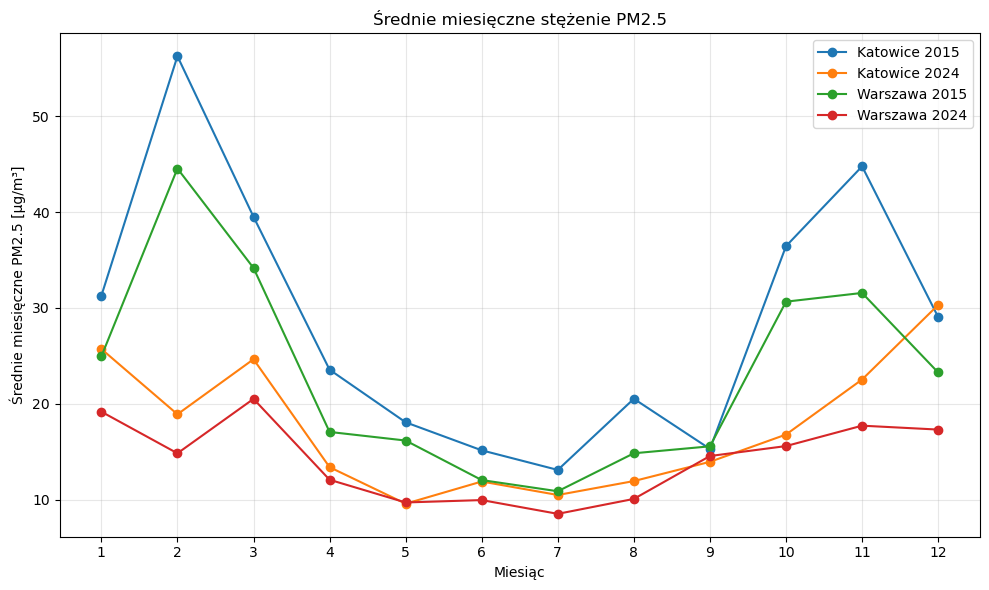

In [ ]:
#wyciągam warszawę i katowice (już w vis.py)
plot_monthly_pm25(
    monthly_city
)

Wykres przedstawia średnie miesięczne stężenia pyłu PM2.5
[
𝜇
𝑔
/
𝑚
3
]
[μg/m
3
] dla dwóch miast: Katowic i Warszawy, porównując dwa lata: 2015 oraz 2024. Oś pozioma odpowiada kolejnym miesiącom roku
(
1
–
12
)
(1–12), natomiast oś pionowa przedstawia średnie miesięczne stężenie PM2.5.

Dla obu miast i analizowanych lat widoczna jest wyraźna sezonowość stężeń PM2.5. Najwyższe wartości występują w miesiącach zimowych (styczeń–marzec oraz listopad–grudzień), natomiast najniższe w okresie letnim (czerwiec–sierpień). Zjawisko to wynika głównie z intensyfikacji emisji w sezonie grzewczym oraz gorszych warunków dyspersji zanieczyszczeń zimą.

Porównanie lat wskazuje na istotne obniżenie poziomu stężeń PM2.5 w 2024 roku w stosunku do 2015 roku, szczególnie w Katowicach. W 2015 roku Katowice charakteryzowały się bardzo wysokimi stężeniami zimą, przekraczającymi miejscami
50

𝜇
𝑔
/
𝑚
3
50μg/m
3
, podczas gdy w 2024 roku wartości te są wyraźnie niższe i nie przekraczają około
30

𝜇
𝑔
/
𝑚
3
30μg/m
3
. W Warszawie również obserwuje się spadek stężeń w 2024 roku, choć skala zmian jest mniejsza niż w przypadku Katowic.

### 3. Heatmapa miesięcznych średnich
Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

In [ ]:
lata_do_heatmapy = [2015, 2018, 2021, 2024]
df_sel = df_all[df_all["Data"].dt.year.isin(lata_do_heatmapy)].copy()
df_long = df_sel.melt(
    id_vars="Data",
    var_name="Kod_stacji",
    value_name="PM25"
)

df_long["PM25"] = pd.to_numeric(df_long["PM25"], errors="coerce")  #żeby był typ numeric

df_long["Miasto"] = df_long["Kod_stacji"].map(kod2miasto)
df_long["Miasto"].isna().sum()
monthly_city = (
    df_long
    .groupby(
        [
            df_long["Data"].dt.year.rename("Rok"),
            df_long["Data"].dt.month.rename("Miesiac"),
            "Miasto"
        ]
    )["PM25"]
    .mean()
    .reset_index()
)

monthly_city.head()



,Rok,Miesiac,Miasto,PM25
0,2015,1,Białystok,22.458108
1,2015,1,Bydgoszcz,23.300085
2,2015,1,Gdańsk,15.260864
3,2015,1,Jelenia Góra,24.520156
4,2015,1,Kalisz,32.039201


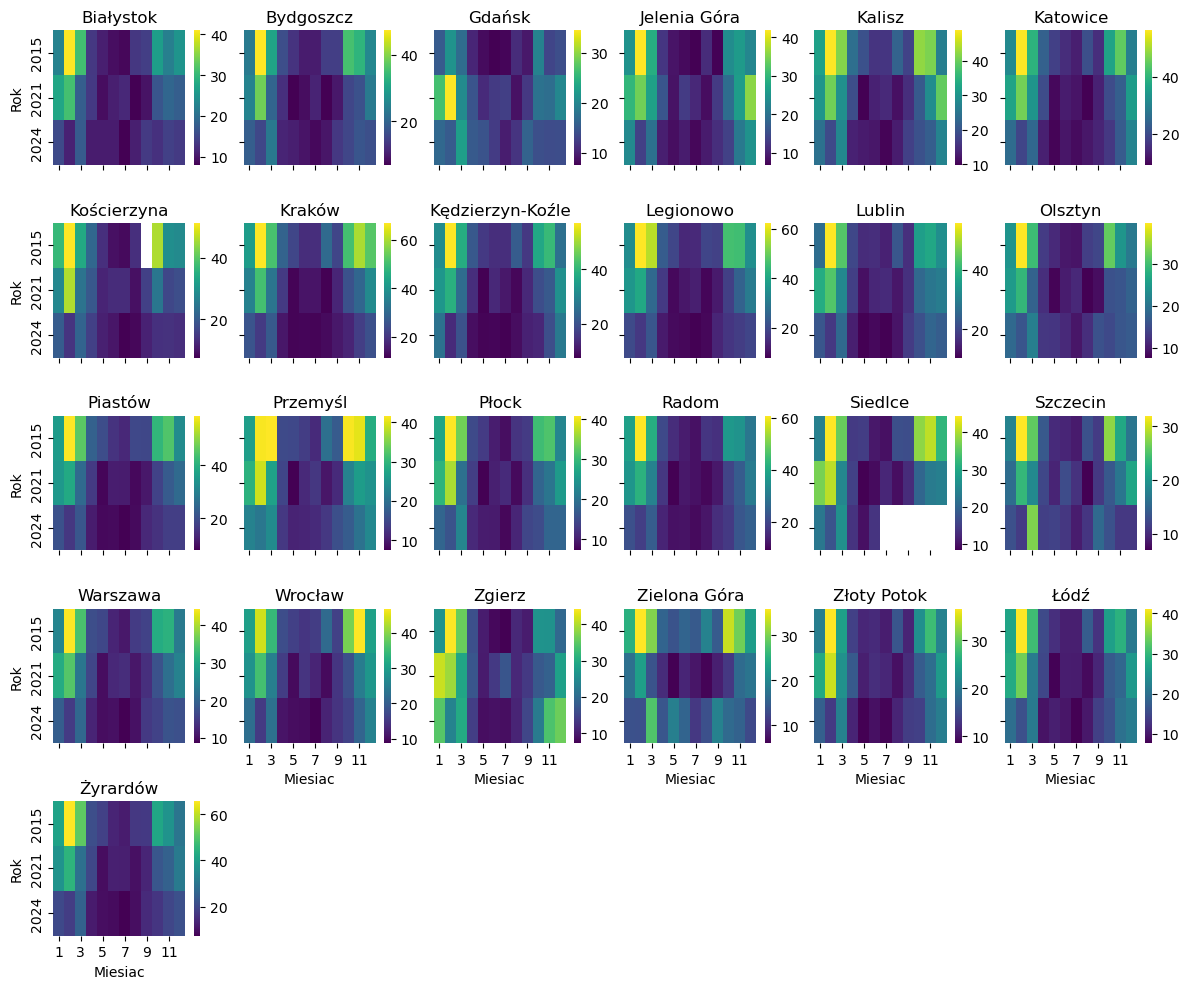

In [ ]:
plot_pm25_heatmaps(monthly_city)

Interpretacja wyników:

W większości miejscowości można zaobserwować stosunkowo podobne trendy (analogiczne do tych zaobserwowanych w zad. 2).
W miesiącach zimowych występują najwyższe stężenia PM2.5 - prawdopodobnie powiązane z ogrzewaniem domów.
W późniejszych latach są stabilnie niższe stężenia PM2.5 - potencjalnie związane z modernizacją systemów grzewczych i zaostrzeniem norm emisji. Pojawiające się w niektórych panelach białe pola odpowiadają brakom danych pomiarowych dla danej kombinacji roku i miesiąca, powstały przez niekompletność danych źródłowych

## Zadanie 5
Przygotuj kod, który wygeneruje wykres pokazujący liczbę dni z przekroczeniem normy stężenia PM2.5 (średnie dzienne stężenie) grupując dane po województwach. Dodaj opis i wyniki do notatnika jako zadanie 5.

In [ ]:
# tworzenie df z potrzebnymi danymi

lata_do_wykresu = [2015, 2018, 2021, 2024]

df_sel = df_all[df_all["Data"].dt.year.isin(lata_do_wykresu)].copy()

df_long = df_sel.melt(
    id_vars="Data",
    var_name="Kod_stacji",
    value_name="PM25"
)

df_long["Miasto"] = df_long["Kod_stacji"].map(kod2miasto)
df_long["Miasto"].isna().sum()

df = df_long.copy()

In [ ]:

df["Data"] = pd.to_datetime(df["Data"])
df["Rok"] = df["Data"].dt.year

# Widzę, że dla 2018 sa przecinki zamiast kropek
df[df['Rok']==2018]['PM25']



8759       43,0102
8760       5,38425
8761       4,52882
8762       8,68036
8763           7,2
            ...   
1034341    17,2711
1034342    18,7469
1034343    23,7844
1034344    20,0236
1034345    32,0525
Name: PM25, Length: 262800, dtype: object

In [ ]:
mask_2018 = df['Rok'] == 2018

# Zamieniam przecinki na kropki w kolumnie 'PM25' dla roku 2018

df.loc[mask_2018, 'PM25'] = (
    df.loc[mask_2018, 'PM25']
      .astype(str)
      .str[::-1]
      .str.replace(',', '.', regex=False)
)

In [ ]:
df['PM25'] = pd.to_numeric(df['PM25'], errors='coerce')
df['PM25'].dtype  # float64

df_daily=daily_station_mean(df)

# Wczytanie metadanych
meta = pd.read_excel('Metadane oraz kody stacji i stanowisk pomiarowych.xlsx')

# Znajdowanie nazw kolumn z Kodem stacji i Województwem
col_stacja = next((col for col in meta.columns if 'Kod stacji' in str(col)), 'Kod stacji')
col_woj = next((col for col in meta.columns if 'Województwo' in str(col)), 'Województwo')

# Mapowanie
mapping = dict(zip(meta[col_stacja], meta[col_woj]))

counts=exceedance_days_per_year(df_daily)
counts['Województwo']=counts["Kod_stacji"].map(mapping)
calosc=(
    counts.groupby(['Rok','Województwo'],as_index=False)['przekracza']
    .mean()
)

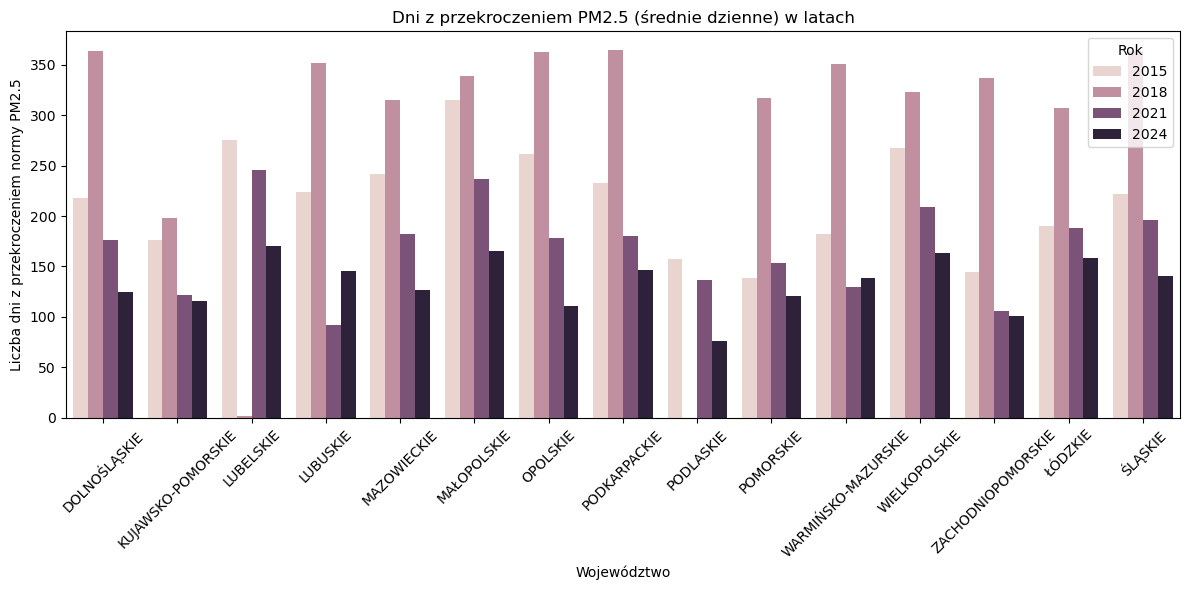

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(
    data=calosc,
    x='Województwo',
    y='przekracza',  # liczba dni z przekroczeniem
    hue='Rok'        # różne lata
)

plt.xticks(rotation=45)
plt.ylabel("Liczba dni z przekroczeniem normy PM2.5")
plt.xlabel("Województwo")
plt.title("Dni z przekroczeniem PM2.5 (średnie dzienne) w latach")
plt.legend(title='Rok')
plt.tight_layout()
plt.show()

### Interpretacja

Rok 2018 był rokiem z największą ilością przekroczeń w większości województw, można to zdarzenie skorelować z długotrwałym niżem, który unosił się w tym roku nad Polską z wyjątkiem wschodu kraju - stąd niskie słupki dla Podlasia i Lubelszczyzny. Po korekcji widać że województwa mające większą średnią ilość przekroczeń to małopolskie, wielkopolskie i lubelskie. Widać tendencję spadkową w każdym województwie z wyjątkiem roku 2018, ale rok 2015 zawsze ma większą ilość wykroczeń od 2024. Można wywnioskować że modernizacja instalacji cieplnych jak i częściowe przejście na czystsze formy pozyskiwania energii mają swoje efekty. Województwa w których jest większa ilość miast albo występuje wyjątkowo duże miasto - np Kraków mają więcej przekroczeń niż inne. Najlepiej wypada województwo podlaskie, które w 2018 roku nie odnotowało żadnych przekroczeń.
